# ANALYSIS OF A BCG SIGNAL

Buriola Lorenzo 2021860\
Leonelli Elena 2028635\
Sabatti Alessandra 1237354\
Sartore Marika 2017916

January 2021

In this notebook, an analysis on a BCG signal from a MuSe sensor is performed in order to estimate the heart. 

In [1]:
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

In [2]:
#colours
colA='royalblue'
colG='darkorange'

## Load the original data

In [3]:
# original dataset
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


## Select only the meaningful data

We proceed as the previous dataset, noticing that the sample frequency of the dataset is Log Freq = 100 Hz. The interval in time we selected is $[10,140]s$.

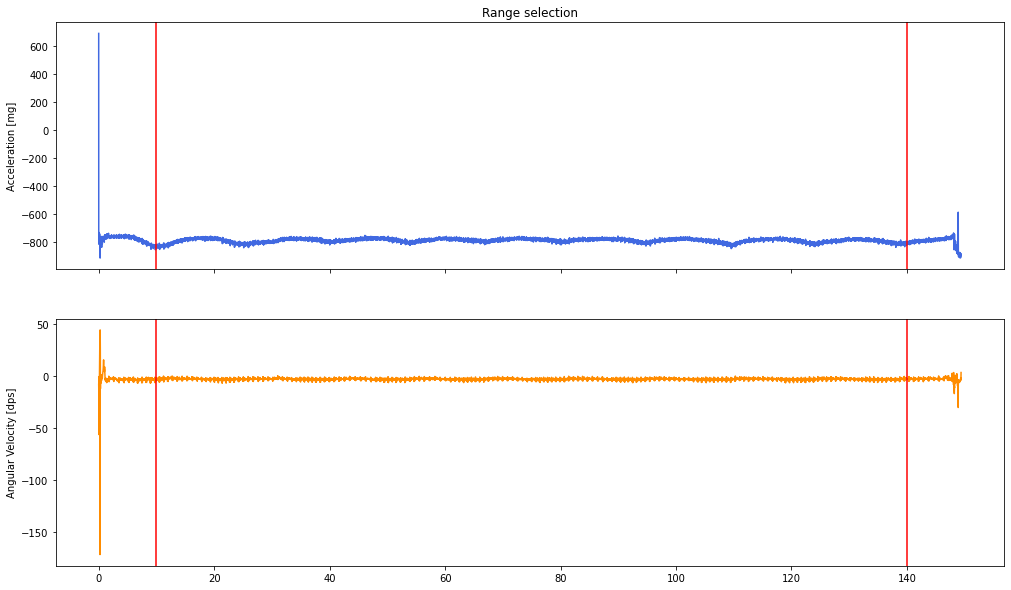

In [60]:
# plot raw data
(fig, (ax1,ax2)) = plt.subplots(2,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'],color=colA)
ax1.axvline(x = 10, color = 'red')
ax1.axvline(x = 140, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'],color=colG)
ax2.axvline(x = 10, color = 'red')
ax2.axvline(x = 140, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

plt.show()

As we saw in the previous analysis of SCG dataset, the measurements of Accelerometer and Gyroscope better describe the system; thus we consider only this two sets for the analysis.

In [5]:
# new dataset with only the interesting data
a = 1000
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk','MagnX','MagnY','MagnZ'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-822.219,-105.957,579.012,-1.829268,0.609756,0.609756,0.00
1001,-818.498,-111.386,577.731,-2.682927,0.731707,0.731707,0.01
1002,-827.587,-108.214,577.670,-4.512195,0.609756,0.731707,0.02
1003,-829.600,-110.105,570.594,-3.536585,1.463415,0.731707,0.03
1004,-833.260,-108.824,563.701,-2.195122,1.341463,0.609756,0.04
...,...,...,...,...,...,...,...
13996,-807.213,-78.019,617.259,-2.682927,0.609756,0.365854,129.96
13997,-803.980,-72.041,616.344,-2.682927,1.219512,0.609756,129.97
13998,-803.065,-78.934,597.068,-2.804878,1.097561,0.243902,129.98
13999,-802.211,-79.788,614.697,-2.682927,1.829268,0.243902,129.99


## Calibration

In [6]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])

In [7]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-818.561316,-128.123523,648.273377,-4.633667,2.402861,0.950927,0.00
1001,-814.835299,-133.565163,646.977212,-5.487326,2.524812,1.072878,0.01
1002,-823.951369,-130.385234,646.870258,-7.316594,2.402861,1.072878,0.02
1003,-826.001308,-132.271361,639.571807,-6.340984,3.256520,1.072878,0.03
1004,-829.702063,-130.977239,632.450211,-4.999521,3.134568,0.950927,0.04
...,...,...,...,...,...,...,...
13996,-803.341688,-100.163103,687.715099,-5.487326,2.402861,0.707024,129.96
13997,-800.102461,-94.167163,686.777527,-5.487326,3.012617,0.950927,129.97
13998,-799.269170,-101.051067,666.925868,-5.609277,2.890666,0.585073,129.98
13999,-798.336075,-101.932782,685.099032,-5.487326,3.622373,0.585073,129.99


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [8]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
mean,-782.610405,-94.627886,707.983191,-5.620871,3.297117,0.622097
median,-780.100191,-94.335121,711.157509,-5.609277,3.256520,0.585073
variance,198.130373,180.768600,491.788827,0.641299,0.901328,0.056764
standard deviation,14.075879,13.445021,22.176312,0.800812,0.949383,0.238252
25% percentile,-791.461692,-103.978008,694.757991,-5.975131,2.646764,0.463122
75% percentile,-772.174827,-84.323690,723.607053,-5.121472,3.866276,0.828976


We use the mean to center the data around 0 in the y-axis.

Correlation coefficients:

In [9]:
# corr.coeff.
M = df.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.728544,0.721530,-0.039568,0.051239,0.009302
AccY,0.728544,1.000000,0.718113,-0.029258,0.045958,-0.029860
AccZ,0.721530,0.718113,1.000000,-0.034282,0.008241,-0.031668
GyroX,-0.039568,-0.029258,-0.034282,1.000000,-0.524570,0.489724
GyroY,0.051239,0.045958,0.008241,-0.524570,1.000000,-0.548018
GyroZ,0.009302,-0.029860,-0.031668,0.489724,-0.548018,1.000000


With respect to the previous dataset, the correlation coefficients among the components of the same instrument are more relevant. This is probably due to the oscillation we can see in the following plot.

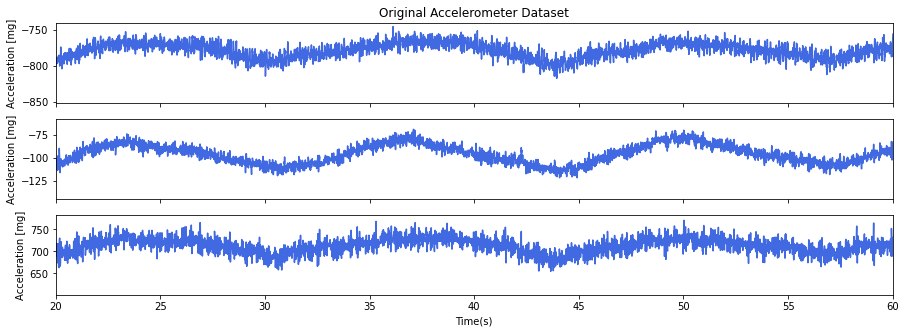

In [61]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(df['Time'],df['AccX'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')

ax[0].set_title('Original Accelerometer Dataset')

ax[1].plot(df['Time'],df['AccY'],color=colA)
ax[1].set_ylabel('Acceleration [mg]')
ax[2].plot(df['Time'],df['AccZ'],color=colA)
ax[2].set_ylabel('Acceleration [mg]')

ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')

plt.show()

We can see that the same oscillation is present in all the components of the accelerometer and gyroscope, with a period around $15s$. For this reason the components correlations are more relevant, and this affects also the variability of the dataset.

After centering the data, we designed a filter to remove this low frequencies component.

## Centering the data

In [11]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-35.950911,-33.495636,-59.709814,0.987204,-0.894256,0.328830,0.00
1001,-32.224895,-38.937276,-61.005979,0.133545,-0.772305,0.450781,0.01
1002,-41.340965,-35.757348,-61.112933,-1.695723,-0.894256,0.450781,0.02
1003,-43.390903,-37.643475,-68.411384,-0.720113,-0.040597,0.450781,0.03
1004,-47.091659,-36.349353,-75.532980,0.621350,-0.162549,0.328830,0.04
...,...,...,...,...,...,...,...
13996,-20.731283,-5.535217,-20.268092,0.133545,-0.894256,0.084928,129.96
13997,-17.492057,0.460723,-21.205664,0.133545,-0.284500,0.328830,129.97
13998,-16.658765,-6.423181,-41.057323,0.011594,-0.406451,-0.037023,129.98
13999,-15.725670,-7.304895,-22.884159,0.133545,0.325256,-0.037023,129.99


In [12]:
#filtering low frequencies (cut-off frequency=0.1)
Sig = dfc.values[:,:-1].T
n_Sig = np.zeros_like(Sig)
for i in range(Sig.shape[0]):
    ft = np.fft.rfft(Sig[i])
    f = np.fft.rfftfreq(len(Sig[i]), 1/freq)
    ft[f < 0.1] = 0
    n_Sig[i] = np.fft.irfft(ft, len(Sig[i]))

dfn = pd.DataFrame(n_Sig.T, columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'])

After this filter we recalculated the variance and the correlation matrix, and we can see that they decreased.

In [13]:
# variance
stat_dfn = pd.DataFrame({'variance': dfn.var()}).T
stat_dfn

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
variance,54.602597,20.949014,187.926273,0.524324,0.69157,0.049929


In [14]:
# correlation coefficients
M = dfn.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.294988,0.172427,0.009658,0.014608,0.050421
AccY,0.294988,1.000000,0.303391,0.076325,0.015768,-0.002925
AccZ,0.172427,0.303391,1.000000,0.022885,-0.070615,-0.019341
GyroX,0.009658,0.076325,0.022885,1.000000,-0.411272,0.406293
GyroY,0.014608,0.015768,-0.070615,-0.411272,1.000000,-0.470671
GyroZ,0.050421,-0.002925,-0.019341,0.406293,-0.470671,1.000000


## PCA

In [16]:
N = dfn.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfn[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfn[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

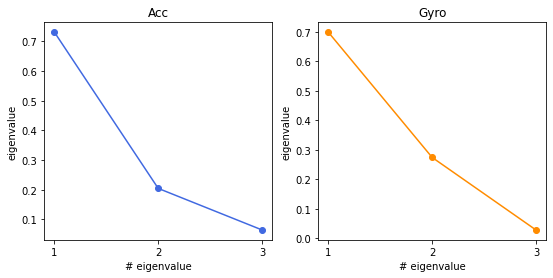

In [17]:
#Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = colA, marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = colG, marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [18]:
print('Eigenvalues and eigenvectors (Acc): \n', avl_acc, '\n\n',U_acc, '\n')
print('Eigenvalues and eigenvectors (Gyro): \n', avl_gyro, '\n\n',U_gyro, '\n')

Eigenvalues and eigenvectors (Acc): 
 [192.54927235  53.90214694  17.02646402] 

 [[-0.13307117  0.96680284  0.21813832]
 [-0.11691521  0.20324628 -0.97212231]
 [-0.98418641 -0.15486514  0.08598773]] 

Eigenvalues and eigenvectors (Gyro): 
 [0.8836895  0.34657325 0.03555983] 

 [[-0.57865026 -0.81143569 -0.08207317]
 [ 0.80513527 -0.58439334  0.10120093]
 [-0.13008106 -0.00752007  0.99147484]] 



From PCA we can see that for the accelerometer Z-component is the most relevant, for gyroscope it is Y.

We notice that the first principal component contains about $70 \%$ of variability, so in the following analysis we will consider only this one for each instrument.
Thus, data was rotated according to the new axes:

In [19]:
# rotated dataset after PCA
rot = np.dot(dfn[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfn[['GyroX','GyroY','GyroZ']],U_gyro)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2]})
dfr['Time'] = df['Time'].values
dfr

,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Time
0,15.491248,-5.080693,7.154127,-0.892206,-0.347657,0.184328,0.00
1,16.870863,-2.368021,13.107089,-0.312097,0.272442,0.387695,0.01
2,17.781577,-10.503280,7.979827,0.652035,1.827638,0.525539,0.02
3,25.422653,-11.723227,8.700495,0.778619,0.536716,0.531909,0.03
4,32.738114,-13.920504,5.984763,-0.076136,-0.480014,0.288608,0.04
...,...,...,...,...,...,...,...
12996,-28.430115,9.125879,-13.122464,-0.385621,0.348900,0.012301,129.96
12997,-28.678783,13.638517,-18.364018,0.077415,-0.009679,0.315886,129.97
12998,-8.485874,16.136148,-13.235909,0.101210,0.162888,-0.049128,129.98
12999,-26.430925,14.061175,-10.651135,0.623588,-0.364079,0.014966,129.99


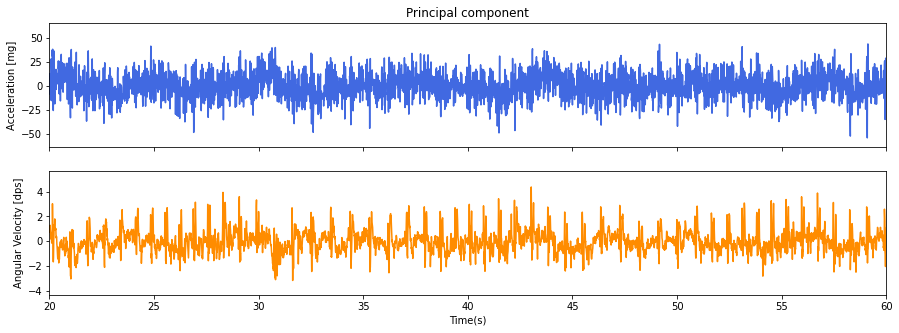

In [62]:
# principal component plots
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'],color=colA)
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('Principal component')
ax[1].plot(dfr['Time'],dfr['Gyro1'],color=colG)
ax[1].set_ylabel('Angular Velocity [dps]')


ax[1].set_xlim(20,60)
ax[1].set_xlabel('Time(s)')

plt.show()

## FFT analysis

For each principal component, we performed the FFT to higlight the heart beat frequency between 40 BPM and 100 BPM.

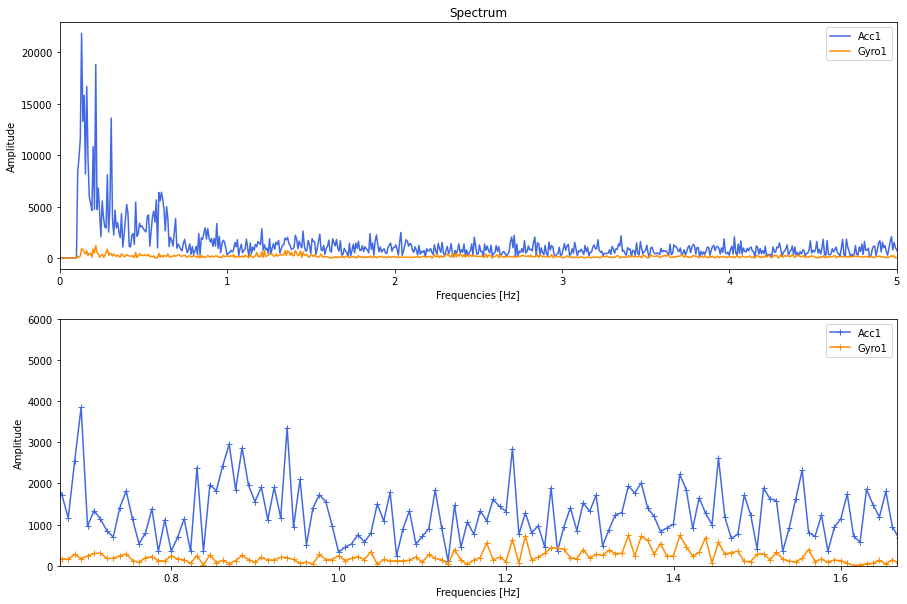

In [63]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
freq_FFT = np.fft.rfftfreq(d=1/freq, n=len(dfr['Acc1']))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT, label='Acc1',color=colA)
ax1.plot(freq_FFT, G1_FFT, label='Gyro1',color=colG)
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'-+', label='Acc1',color=colA)
ax2.plot(freq_FFT, G1_FFT,'-+', label='Gyro1',color=colG)
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

plt.show()

In this case applying the pure FFT does not give a clear result. The spectrum does not display any particular frequence peak that can suggest the right heart beat, in both gyroscope and accelerometer. We need to proceed with the analysis, in order to extract results from this dataset.

## SIGNAL PROCESSING

As before, our signal processing pipeline is the following:

- Discrete wavelet transform: in this case a $3$ level dwt was performed and only the detailed coefficients corresponding to a band of $[6.25, 25]\;Hz$ are kept. We have changed the upper frequency limit with respect to the previous analysis because this signal is way more noisy and the wavelet corresponding to $[25, 50] \;Hz$ worsens the quality of the signal.
- Signal envelope
- Bandpass filter $[0.66, 6]\;Hz$ 


In [92]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

In [93]:
# wavelet
def wavelet_decomposition(t, signal, n, wave_name, color):
    coeff = pywt.wavedec(signal, wave_name, level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, wave_name)
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

def wavelet_filter(coeff, index, wave_name):
    for j in range(len(coeff)):
        if j not in index: 
            coeff[j] = np.zeros_like(coeff[j])
    sig_w = pywt.waverec(coeff, wave_name)
    return sig_w[:-1]

In [94]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/100)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


 ## Gyroscope

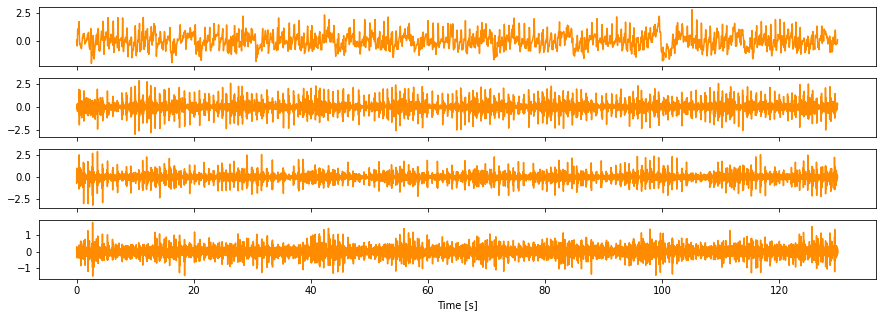

In [95]:
n=3
wave_name='sym4'
CG = wavelet_decomposition(t, sigG, n, wave_name ,color=colG)

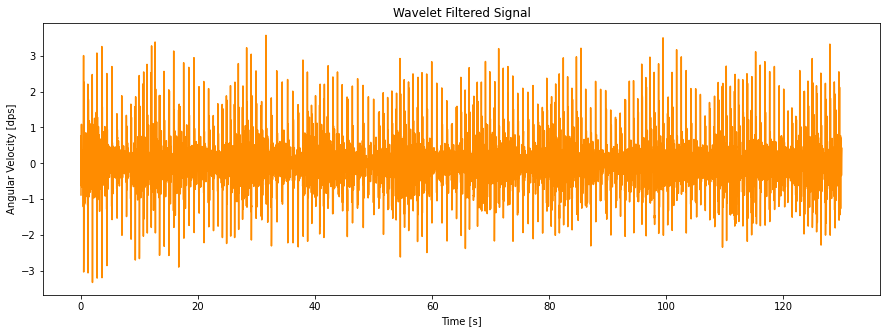

In [97]:
# filtered signal after wavelet decomposition
cg = CG.copy()
SIGG = wavelet_filter(cg, [1,2], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGG,color=colG)
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')
plt.show()

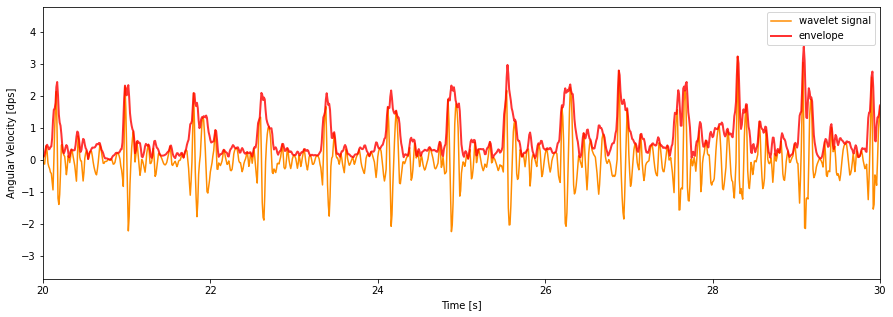

In [99]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color=colG, label='wavelet signal')
plt.plot(t, SIGG_h, color = 'red',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.show()

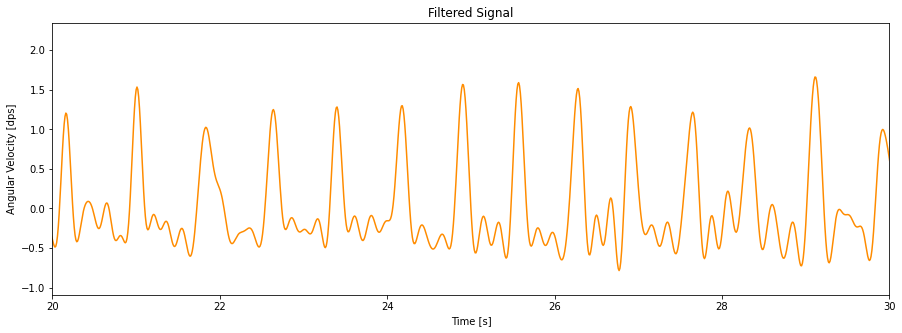

In [100]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G ,color=colG)
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

## Accelerometer

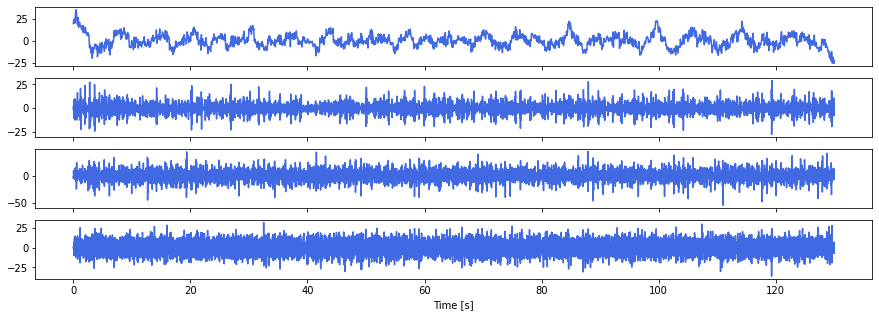

In [29]:
CA = wavelet_decomposition(t, sigA, n, wave_name,color=colA)


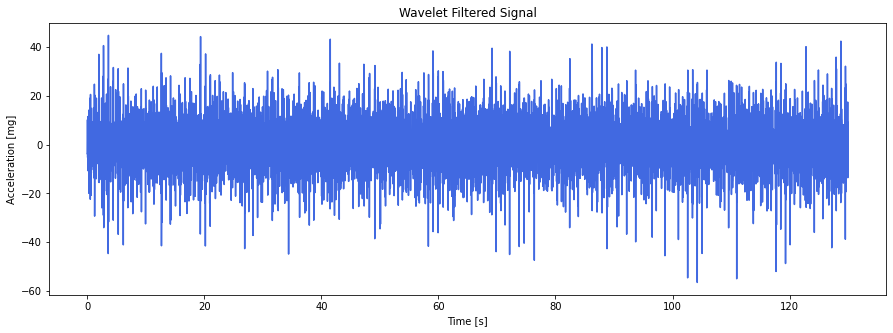

In [101]:
# filtered signal after wavelet decomposition
ca = CA.copy()
SIGA = wavelet_filter(ca, [1,2], wave_name)

plt.figure(figsize=(15,5))
plt.plot(t, SIGA,color=colA)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')
plt.show()

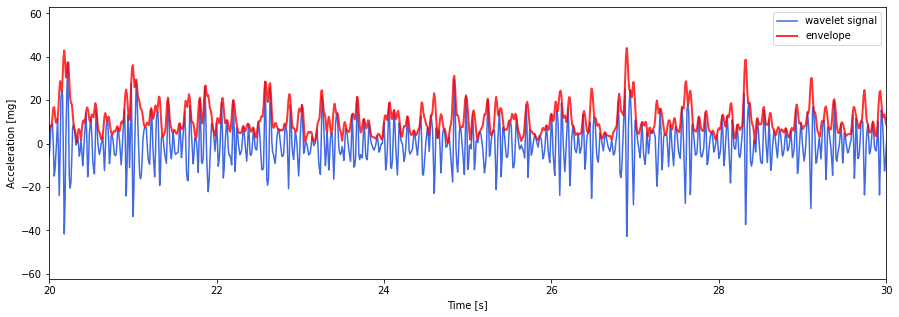

In [102]:
# envelope
SIGA_h = np.abs(signal.hilbert((SIGA)))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA,color=colA, label='wavelet signal')
plt.plot(t, SIGA_h, color = 'r',alpha=0.8, linewidth=2, label='envelope')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.show()

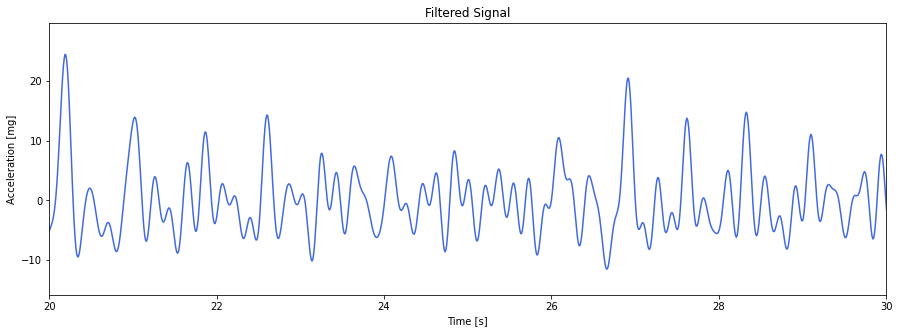

In [103]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A ,color=colA)
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')
plt.show()

## Find peaks

As in the previous analysis, we perform a peak analysis on the filtered data with __find_peaks__. When it fails the peaks are fixed with the function __fix_peaks__ mentioned before

In [106]:
# function to plot HRV and BPM histo
def histo_func(bins1,peaks1,t,color,label):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o',color=color,label=label)
    ax_main.legend()
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal',color=color)
    ax_marg.set_xlabel('Freq.')
    ax_marg.set_ylim(l)

In [107]:
def single_fix(time,peaks,data,thr, r = 0.5):
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):

        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])

        if to_check>1.5*(diff_mean):

            if period[i]-period[i+1]>0 and data[peaks_new[i+1]] < thr:
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]                    

            elif period[i]-period[i+1]<0 and data[peaks_new[i+1]] < thr: #
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]
    return peaks_new

def fix_peaks(time,peaks,data,thr, r,iteration,color,ylabel):
    peaks0 = peaks
    for j in range(iteration):
        peaks_new = single_fix(time,peaks,data,thr, r = 0.5)
        if all(peaks == peaks_new):
            print('fix_peaks exited after %s iterations' %j)
            break
        peaks = peaks_new

    plt.figure(figsize=(15,4))
    plt.plot(time,data,color=color)
    #plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks0],data[peaks0], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.ylabel(ylabel)
    plt.xlabel('Time [s]')
    plt.legend(loc='upper right')
    return peaks_new

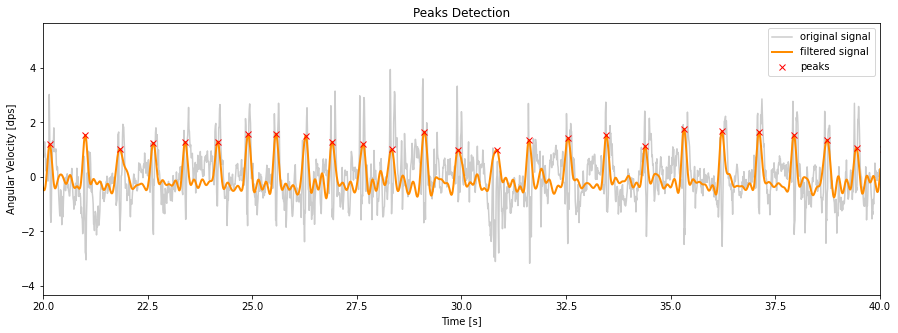

In [113]:
# gyroscope peaks
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal',color=colG,linewidth=2)
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=50)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

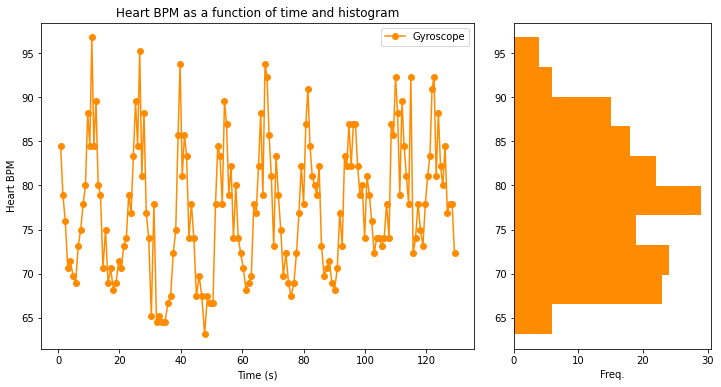

In [109]:
# HRV and BPM histo
histo_func(10,peaksG,t.values,color=colG,label='Gyroscope')

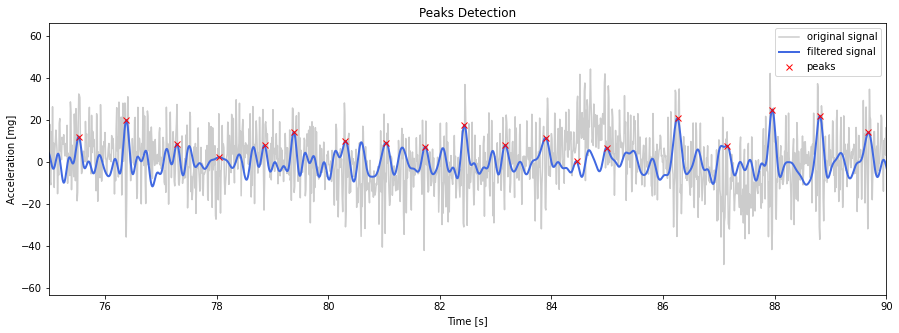

In [112]:
# accelerometer
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal',color=colA,linewidth=2)
peaksA,_ = signal.find_peaks(signal_A, height=-5 , distance=52)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(75,90)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')
plt.show()

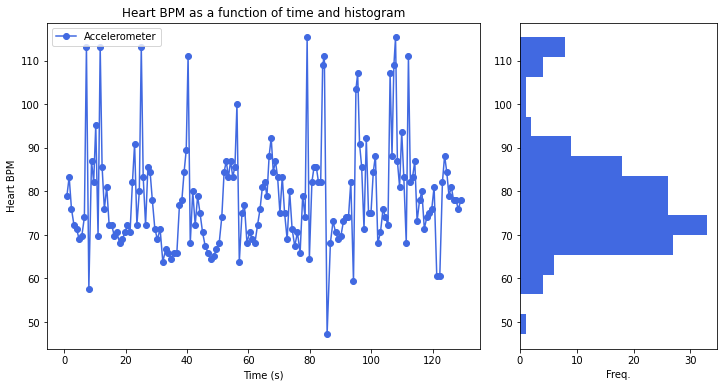

In [54]:
# HRV and BPM histo
histo_func(15,peaksA,t.values,color=colA,label='Accelerometer')

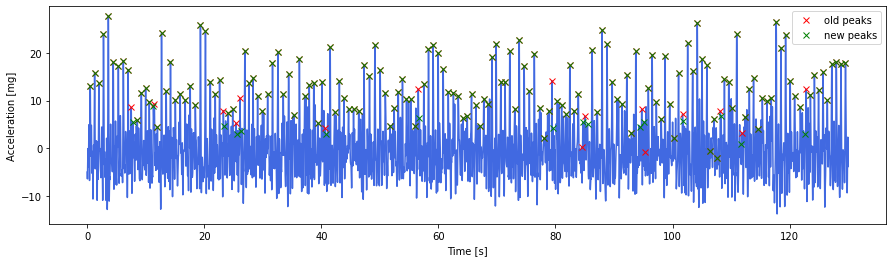

In [39]:
# fixed peaks for the accelerometer
peaks_new_A = fix_peaks(t.values,peaksA,signal_A,thr=15,r=0.4, iteration = 3,color=colA,ylabel='Acceleration [mg]')

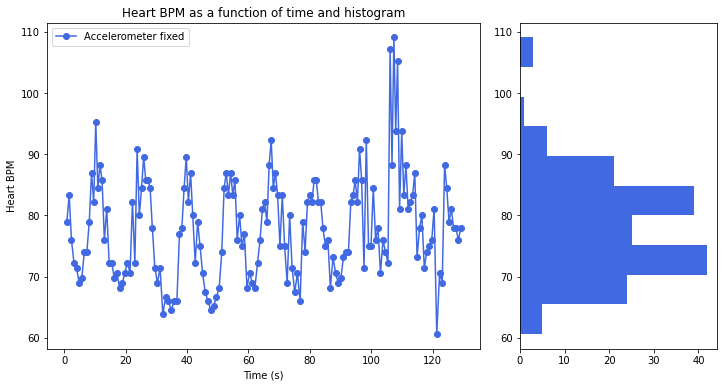

In [40]:
histo_func(10,peaks_new_A,t.values,color=colA,label='Accelerometer fixed')

In the case of accelerometer, the function __fix_peaks__ manages to fix the peaks up to $100 \; s$. In the last $40 \; s$ some errors appears. They are probably due to the fact that around $110\; s$ the __find_peaks__ algorithm finds an additional peak (with respect to the ones detected with the gyroscope) and at $120 \; s$ it loses a peak. This causes some irregularities that our function cannot fix.

### Comparison between the two instruments results


Also in this case we proceeed with the comparison between the two signal peaks detection.

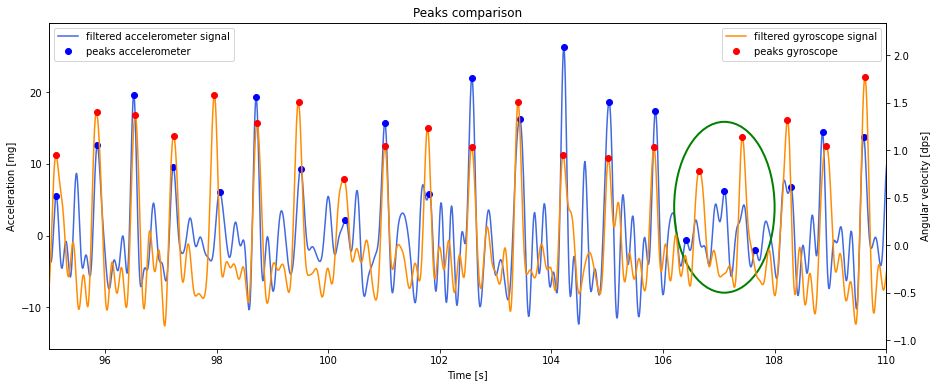

N° of peaks found from Gyroscope signal: 167 
N° of peaks found from Accelerometer signal: 167


In [153]:
from matplotlib.patches import Circle
fig,ax1=plt.subplots(figsize=(15,6))


ax1.plot(t,signal_A,label='filtered accelerometer signal',color=colA)
ax1.plot(t[peaks_new_A],signal_A[peaks_new_A], 'bo', label='peaks accelerometer')
ax1.tick_params(axis='y')
ax2=ax1.twinx()
ax2.plot(t,signal_G,label='filtered gyroscope signal',color=colG)
ax2.plot(t[peaksG],signal_G[peaksG], 'ro', label='peaks gyroscope')
ax2.tick_params(axis='y')
ax1.set_ylabel('Acceleration [mg]')
ax2.set_ylabel('Angular velocity [dps]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(95, 110)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Peaks comparison')
circ = Circle((107.1, 0.4), 0.9, fc = 'None', ec = 'green', alpha = 1, lw = 2)
ax2.add_patch(circ)
plt.show()

print('N° of peaks found from Gyroscope signal: %s \nN° of peaks found from Accelerometer signal: %s' %(len(peaksG),len(peaksA)))

As we underlined before, although the number of points is the same, there are some regions where the peaks do not coincide. 

In the next cell we print the number of beats within a minute extracted from data

In [115]:
#number of heart beats in one minute
print('N° beats in one minute Gyroscope: %.2f' %((len(peaksG)-1)/(t.values[peaksG[-1]]-t.values[peaksG[0]])*60))
print('N° beats in one minute Accelerometer: %.2f' %((len(peaks_new_A)-1)/(t.values[peaks_new_A[-1]]-t.values[peaks_new_A[0]])*60))

N° beats in one minute Gyroscope: 77.15
N° beats in one minute Accelerometer: 77.19


# Peaks errors and KDE

The errors of the peaks for the BCG signal are overall greater than the previous ones because the peaks are less defined and larger. Notice that in the case of accelerometer some peaks are smaller because of the noise. 

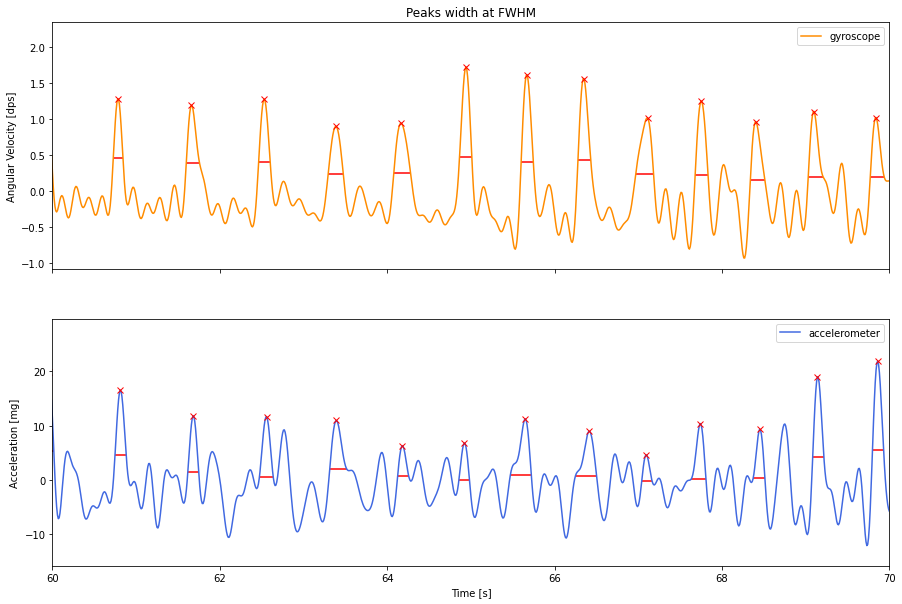

In [161]:
# gyroscope
widthsG = signal.peak_widths(signal_G, peaksG, rel_height=0.5)
# accelerometer
widthsA = signal.peak_widths(signal_A, peaks_new_A, rel_height=0.5)

fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)
ax[0].plot(t.values,signal_G,label='gyroscope',color=colG)
ax[0].plot(t.values[peaksG], signal_G[peaksG],'rx')
ax[0].hlines(widthsG[1],xmin=0.01*widthsG[2],xmax=0.01*widthsG[3],color='red')
ax[0].set_xlim(30,40)
ax[0].set_ylabel('Angular Velocity [dps]')
ax[0].set_title('Peaks width at FWHM')
ax[0].legend()
ax[1].plot(t.values,signal_A,label='accelerometer',color=colA)
ax[1].plot(t.values[peaks_new_A], signal_A[peaks_new_A],'rx')
ax[1].hlines(widthsA[1],xmin=0.01*widthsA[2],xmax=0.01*widthsA[3],color='red')
ax[1].set_xlim(60,70)
ax[1].set_ylabel('Acceleration [mg]')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

plt.show()

In [162]:
def kde_func(widths,time,peaks):
    const = 2*(2*np.log(2))**0.5
    sigma = widths[0]/const*0.01

    peaks_time=np.array(time.values[peaks])

    period = peaks_time[1:] - peaks_time[:-1]
    sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
    rate = 1/period*60
    err_rate = rate/period*sigma_period

    #KDE 
    xx = np.linspace(min(rate),max(rate),1000)
    fx = np.zeros(xx.shape)
    for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
        fx += norm.pdf(xx,r,s)
    fx = fx/trapz(fx,xx)
    return xx,fx,rate,err_rate

xxG,fxG,rateG,err_rateG = kde_func(widthsG,t,peaksG)
xxA,fxA,rateA,err_rateA = kde_func(widthsA,t,peaks_new_A)

## Results

Finally we report the results as we did for the SCG signal:

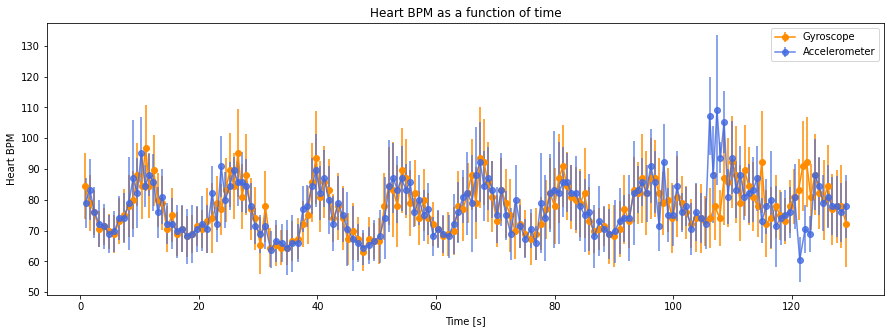

In [160]:
plt.figure(figsize=(15,5))
plt.errorbar((t.values[peaksG][1:]+t.values[peaksG][:-1])*0.5,rateG,err_rateG,marker='o',color=colG,label='Gyroscope')
plt.errorbar((t.values[peaks_new_A][1:]+t.values[peaks_new_A][:-1])*0.5,rateA,err_rateA,marker='o',color=colA,label='Accelerometer',alpha=0.8)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Heart BPM')
plt.title('Heart BPM as a function of time')
plt.show()

Also in this case the hearth rate oscillates during the time interval mainly between 

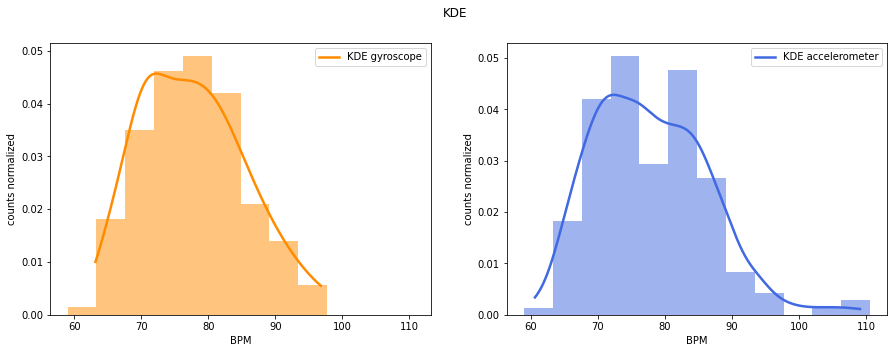

In [157]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

bins=np.arange(59,111,4.3)
ax[0].hist(rateG, bins=bins, density=True,color=colG, alpha=0.5)
ax[0].plot(xxG, fxG, linewidth=2.5, linestyle='solid',label='KDE gyroscope',color=colG)
ax[0].set_xlabel('BPM')
ax[0].set_ylabel('counts normalized')
ax[0].legend()
ax[1].hist(rateA, bins=bins, density=True,color=colA, alpha=0.5)
ax[1].plot(xxA, fxA, linewidth=2.5, linestyle='solid',label='KDE accelerometer',color=colA)
ax[1].set_xlabel('BPM')
ax[1].set_ylabel('counts normalized')
ax[1].legend()
fig.suptitle('KDE')
plt.show()

In [56]:
#BPM mean with weights
meanG = np.average(rateG, weights=1/err_rateG**2)
meanA=np.average(rateA,weights=1/err_rateA**2)
err_meanA = (1/np.sum(1/err_rateA**2))**0.5
err_meanG = (1/np.sum(1/err_rateG**2))**0.5

print('BPM Gyroscope: %.1f +/- %.1f BPM' %(meanG, err_meanG))
print('BPM Accelerometer: %.1f +/- %.1f BPM' %(meanA, err_meanA))

BPM Gyroscope: 74.6 +/- 0.7 BPM
BPM Accelerometer: 76.2 +/- 0.7 BPM


## Conclusions

-Siamo riusciti a trovare un metodo per estrarre le info necessarie dai dati per i BPM con un analisi anche temporale (ridire la pipeline + PCA + peaks)

-SCG: ottimo accordo tra i dati del giro e acc. Accordo con analisi preliminare FFT

-BCG: non ottimo accordo tra i due strumenti, dovuto a maggior rumore e minor definizione dei segnali. In particolare il segnale dell'accelerometro, anche dopo la pipeline di filtraggio mostra delle imperfezioni, per cui estrarre i picchi è risultato più complesso. Analisi preliminare infattibile.

-Abbiamo usato un simple algorithm per poter correggere l'analisi dei picchi anche quando il filtro non li esaltava: la correzione ha migliorato i risultati in tutti i casi. Tuttavia nel caso dell'acc BCG non siamo riusciti ad ottenre lo stesso andamento del giroscopio ma uno più irregolare nella parte finale del tempo.

-In generale ci sembra di poter dire che le lo strumento migliore da utilizzare per l'analisi del battito cardiaco sia il giroscopio per pulizaia del segnale ed evidenza dei picchi.

-I risultati ottenuti sono coerenti tra i singoli dataset

In [ ]:
DA FARE:
    finire i commenti su SWEATER
    aggiungere spettro frequenza dopo filtro
    Scrivere le conclusioni